# Chapter 2

## Transformers as Feature Extractors, p. 38

### Starting off with a pre-trained DistilBERT model

See [`distilbert-base-uncased`](https://huggingface.co/distilbert-base-uncased) at 🤗 Models.

We choose our checkpoint here, and start off by setting up a tokenizer.

In [1]:
checkpoint = "distilbert-base-uncased"

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


----

### Load up the dataset

See p.35, __Tokenizing the Whole Dataset__.

We start off by obtaining a dataset of tweets, and then we will tokenize the entire dataset in one go.

Note that the original `emotion` dataset is long gone. We are using [`SetFit/emotion`](https://huggingface.co/datasets/SetFit/emotion) dataset from 🤗 Datasets.

Key APIs are:

* [`datasets.load_dataset`](https://huggingface.co/docs/datasets/loading#hugging-face-hub)
* [`dataset.map`](https://huggingface.co/docs/datasets/process#map)

First, we load up the `SetFit/emotion` dataset from 🤗 Datasets, by simply providing the repository _namespace_ and _dataset name_.

In [4]:
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")
emotions

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

Define a custom function for tokenizing the text in the dataset.

In [5]:
def tokenize_text(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

> The primary purpose of `map()` is to speed up processing functions. It allows you to apply a processing function to each example in a dataset, independently or in batches. This function can even create new rows and columns.

Here we use `map` to efficiently apply our custom `tokenize_text` function to the entire dataset. Using `batch_size=None`, we ensure that the input tensors and attention masks have the exact same shape globally. See [`batch_size`](https://huggingface.co/docs/datasets/v2.8.0/en/package_reference/main_classes#datasets.Dataset.map.batch_size) parameter for `map` API.

In [6]:
emotions_encoded = emotions.map(tokenize_text, batched=True, batch_size=None)
emotions_encoded

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-ad2649c8346e0844.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c254f6d248d17bc6.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

----

### Using pretrained models

In [7]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
print(model.config)
print(model.device)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

cuda:0


----

### Extracting the last hidden states

See [What is purpose of the [CLS] token and why is its encoding output important?](https://datascience.stackexchange.com/questions/66207/what-is-purpose-of-the-cls-token-and-why-is-its-encoding-output-important)

In [9]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Inputs tensor shape: {inputs['input_ids'].size()}")

Inputs tensor shape: torch.Size([1, 6])


Take the inputs and place them on the same device as `model`.

[`torch.no_grad`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) is gives us a context-manager for use 

> ... when you are sure that you will not call `Tensor.backward()`. It will reduce memory consumption for computations that would otherwise have `requires_grad=True`.

In [10]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [11]:
print(f"Outputs tensor shape: {outputs.last_hidden_state.size()}")

Outputs tensor shape: torch.Size([1, 6, 768])


In [12]:
print(f"Last hidden state tensor for the [CLS] token: {outputs.last_hidden_state[:, 0].size()}")

Last hidden state tensor for the [CLS] token: torch.Size([1, 768])


In [13]:
def extract_hidden_states(batch):
    # place model inputs on the GPU
    inputs = { 
        k:v.to(device) 
        for k,v in batch.items()
        if k in tokenizer.model_input_names
    }
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for the [CLS] token
    # ... putting it back on the CPU,
    # ... and returning as a Numpy object
    return { 
        "hidden_state": last_hidden_state[:,0].cpu().numpy()
    }


In [14]:
emotions_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

In [15]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-47e14bfcb9a153d7.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-f7d31b7a859953f9.arrow


In [16]:
emotions_hidden["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

In [17]:
emotions_hidden["test"]["hidden_state"]

tensor([[-0.0216,  0.1965,  0.0041,  ..., -0.0646,  0.4319,  0.5599],
        [-0.0165,  0.3204, -0.0225,  ..., -0.1050,  0.4260,  0.4670],
        [-0.1114,  0.0211, -0.2773,  ..., -0.0317,  0.2478,  0.2088],
        ...,
        [ 0.1405,  0.0942, -0.0726,  ...,  0.0361,  0.3638,  0.1618],
        [-0.0996,  0.2276,  0.0766,  ..., -0.0227,  0.3045,  0.5173],
        [ 0.0641,  0.1125, -0.0785,  ...,  0.0009,  0.3229,  0.4590]])

----

### Creating a feature matrix

In [18]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [19]:
import pandas as pd

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler


# scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# initialize and fit UMAP
mapper = UMAP(
    n_components=2,
    metric="cosine"
).fit(X_scaled)

# create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.356847,6.564123,0
1,-2.940133,5.742152,0
2,5.548778,3.126408,3
3,-2.434765,3.624641,2
4,-3.298133,3.760247,3


In [20]:
id2str = dict(
    zip(
        emotions["train"].unique('label'), 
        emotions["train"].unique('label_text')
    )
)

id2str = dict(sorted(id2str.items(), key=lambda item: item[0]))
id2str

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

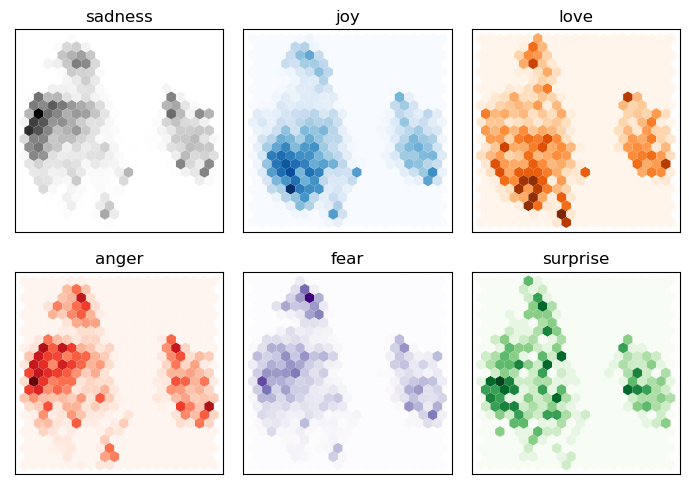

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = id2str.values()

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub["X"], 
        df_emb_sub["Y"],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

----

### Training a simple classifier

In [22]:
from sklearn.linear_model import LogisticRegression

# "increase max_iter to guarantee convergence"...
# ... wat?
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

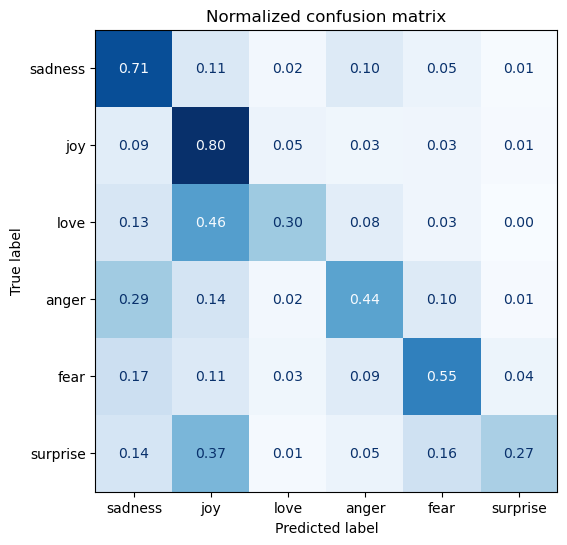

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(
        cmap="Blues",
        values_format=".2f",
        ax=ax,
        colorbar=False
    )
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

----

### Using the Logistic Regression Classifier

Now let's see about using our classifer on the sample tweet below.

In [25]:
tweet = "Happy New Year, everyone! Peace & love to all"

From page 38:

> This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

In keeping with this, we will move `model` back to the CPU. Note the we will require `tokenizer` and `model` to transform any input tweets and obtain the `last_hidden_state` of the `[CLS]` to use as input our Logistic Regression based classifier.

In [26]:
model.to("cpu")
model.device

device(type='cpu')

To use our classifier:

* Transform an input sample tweet to a vector representation (`[CLS]`)
* Don't forget to use `no_grad`
* Don't forget to transform that output back into a Numpy array
* Use `id2str` to get the final label text of the prediction

In [27]:
inputs = tokenizer(tweet, return_tensors="pt")
inputs = {k:v for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

tweet_cls = outputs.last_hidden_state[:, 0].numpy()

y = lr_clf.predict(tweet_cls)

print()
print(f"Sample tweet '{tweet}' is: {id2str[y[0]]}")

BaseModelOutput(last_hidden_state=tensor([[[-0.1307, -0.1720,  0.2535,  ...,  0.0320,  0.4328,  0.1663],
         [-0.1272,  0.1782,  0.6252,  ..., -0.0998,  0.7243, -0.0708],
         [-0.3294, -0.0272,  0.7579,  ...,  0.0532,  0.6076, -0.7313],
         ...,
         [ 0.1109,  0.5428,  0.9294,  ...,  0.3347,  0.1849, -0.1974],
         [-0.4488, -0.0275,  0.9289,  ...,  0.0542,  0.5971, -0.4348],
         [ 0.8959,  0.2133, -0.2652,  ...,  0.0422, -0.4122, -0.2742]]]), hidden_states=None, attentions=None)

Sample tweet 'Happy New Year, everyone! Peace & love to all' is: joy
